In [12]:
# Irish News NLP - Topic Classification + Sentiment

# Step 1: Install and import libraries

!pip install nltk --quiet

import os
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)

import nltk
import re
import string

from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

# download NLTK stuff
nltk.download('stopwords')
nltk.download('vader_lexicon')

sns.set_theme()

STOPWORDS = set(stopwords.words("english"))
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [13]:
# Step 2: Extract the dataset zip file
# Make sure you upload "IrishTimes_News_Dataset.zip" on the left side in Colab

ZIP_NAME = "IrishTimes_News_Dataset.zip"
zip_path = os.path.join("/content", ZIP_NAME)

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall("/content/")
    print("Zip extracted.")
else:
    print("Zip file not found. Please upload IrishTimes_News_Dataset.zip first.")

print(os.listdir("/content"))

Zip extracted.
['.config', 'IrishTimes_News_Dataset.zip', 'new_IrishTimes_test.txt', 'new_IrishTimes_train.txt', 'new_IrishTimes_train_label.txt', 'new_IrishTimes_test_label.txt', 'sample_data']


In [14]:
# Step 3: Set file paths and create some helper functions

train_txt_path = "/content/new_IrishTimes_train.txt"
train_label_path = "/content/new_IrishTimes_train_label.txt"
test_txt_path = "/content/new_IrishTimes_test.txt"
test_label_path = "/content/new_IrishTimes_test_label.txt"

for path in [train_txt_path, train_label_path, test_txt_path, test_label_path]:
    print(path, "exists:", os.path.exists(path))


def read_lines(path, encoding="utf-8"):
    """Read text file and return list of lines."""
    with open(path, "r", encoding=encoding, errors="ignore") as f:
        lines = [line.strip() for line in f.readlines()]
    return lines


def clean_text(text):
    """Simple text cleaning for NLP."""
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", "", text)        # remove links
    text = re.sub(r"\d+", "", text)                     # remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = text.split()
    tokens = [w for w in tokens if w not in STOPWORDS]  # remove stopwords
    return " ".join(tokens)

/content/new_IrishTimes_train.txt exists: True
/content/new_IrishTimes_train_label.txt exists: True
/content/new_IrishTimes_test.txt exists: True
/content/new_IrishTimes_test_label.txt exists: True


In [15]:
# Step 4: Load data into DataFrames

X_train_raw = read_lines(train_txt_path)
y_train_raw = read_lines(train_label_path)

X_test_raw = read_lines(test_txt_path)
y_test_raw = read_lines(test_label_path)

print("Train samples:", len(X_train_raw), "labels:", len(y_train_raw))
print("Test samples:", len(X_test_raw), "labels:", len(y_test_raw))

# quick check
assert len(X_train_raw) == len(y_train_raw), "train text and label length mismatch"
assert len(X_test_raw) == len(y_test_raw), "test text and label length mismatch"

train_df = pd.DataFrame({"text": X_train_raw, "label": y_train_raw})
test_df = pd.DataFrame({"text": X_test_raw, "label": y_test_raw})

# add cleaned text column
train_df["clean_text"] = train_df["text"].astype(str).apply(clean_text)
test_df["clean_text"] = test_df["text"].astype(str).apply(clean_text)

train_df.head()

Train samples: 145034 labels: 145034
Test samples: 16114 labels: 16114


,text,label,clean_text
0,Oil price drops again as Iraq's output reaches...,business,oil price drops iraqs output reaches record level
1,Who Will Speak For Children?,opinion,speak children
2,Election posters push a Merkel referendum,news,election posters push merkel referendum
3,Clarke survives Little's late surge,sport,clarke survives littles late surge
4,RUC says 'freelance' gunman killed taxi-driver,news,ruc says freelance gunman killed taxidriver


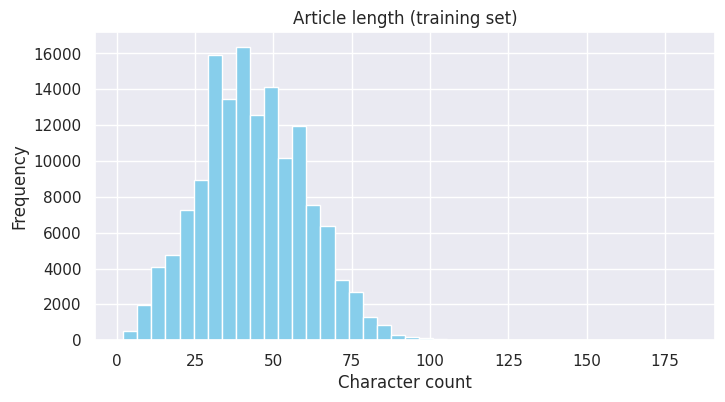

In [16]:
# Step 5: Quick look at article length and labels

train_df["length"] = train_df["text"].str.len()

plt.figure(figsize=(8, 4))
train_df["length"].hist(bins=40, color="skyblue")
plt.title("Article length (training set)")
plt.xlabel("Character count")
plt.ylabel("Frequency")
plt.show()

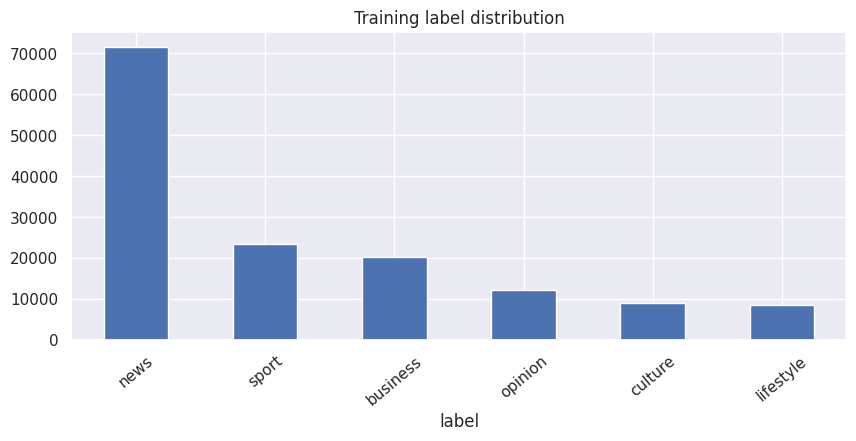

Labels: ['business', 'culture', 'lifestyle', 'news', 'opinion', 'sport']


In [17]:
plt.figure(figsize=(10, 4))
train_df["label"].value_counts().plot(kind="bar")
plt.title("Training label distribution")
plt.xticks(rotation=40)
plt.show()

print("Labels:", sorted(train_df["label"].unique()))

In [18]:
# Step 6: TF-IDF features + train SVM and Logistic Regression

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=2
)

X_train_vec = tfidf.fit_transform(train_df["clean_text"])
X_test_vec = tfidf.transform(test_df["clean_text"])

y_train = train_df["label"].values
y_test = test_df["label"].values

print("Train shape:", X_train_vec.shape)
print("Test shape :", X_test_vec.shape)

Train shape: (145034, 20000)
Test shape : (16114, 20000)


=== Linear SVM ===
              precision    recall  f1-score   support

    business       0.66      0.62      0.64      2211
     culture       0.55      0.43      0.48       954
   lifestyle       0.62      0.45      0.52       986
        news       0.75      0.82      0.79      8012
     opinion       0.56      0.41      0.48      1331
       sport       0.73      0.79      0.76      2620

    accuracy                           0.71     16114
   macro avg       0.65      0.59      0.61     16114
weighted avg       0.70      0.71      0.70     16114



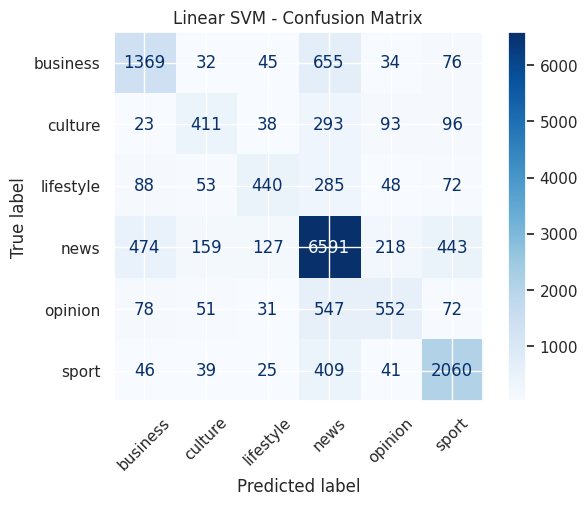

In [19]:
# Model 1: Linear SVM
svm_model = LinearSVC()
svm_model.fit(X_train_vec, y_train)
y_pred_svm = svm_model.predict(X_test_vec)

print("=== Linear SVM ===")
print(classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(cm_svm, display_labels=svm_model.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Linear SVM - Confusion Matrix")
plt.show()

=== Logistic Regression ===
              precision    recall  f1-score   support

    business       0.70      0.58      0.64      2211
     culture       0.63      0.39      0.49       954
   lifestyle       0.68      0.39      0.50       986
        news       0.71      0.87      0.78      8012
     opinion       0.68      0.31      0.43      1331
       sport       0.74      0.77      0.76      2620

    accuracy                           0.71     16114
   macro avg       0.69      0.55      0.60     16114
weighted avg       0.70      0.71      0.69     16114



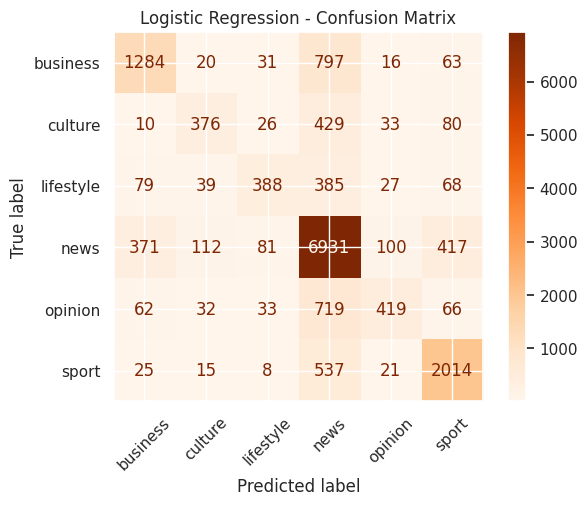

In [20]:
# Model 2: Logistic Regression
log_model = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
log_model.fit(X_train_vec, y_train)
y_pred_log = log_model.predict(X_test_vec)

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_log))

cm_log = confusion_matrix(y_test, y_pred_log, labels=log_model.classes_)
disp2 = ConfusionMatrixDisplay(cm_log, display_labels=log_model.classes_)
disp2.plot(cmap="Oranges", xticks_rotation=45)
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

In [21]:
# Compare both models (accuracy and weighted F1)

svm_acc = accuracy_score(y_test, y_pred_svm)
log_acc = accuracy_score(y_test, y_pred_log)

svm_f1 = f1_score(y_test, y_pred_svm, average="weighted")
log_f1 = f1_score(y_test, y_pred_log, average="weighted")

print("Model comparison:")
print(f"SVM  -> accuracy: {svm_acc:.3f}, weighted F1: {svm_f1:.3f}")
print(f"LOG  -> accuracy: {log_acc:.3f}, weighted F1: {log_f1:.3f}")

Model comparison:
SVM  -> accuracy: 0.709, weighted F1: 0.701
LOG  -> accuracy: 0.708, weighted F1: 0.692


In [22]:
# Step 8: Small helper to test the model on custom text

def predict_topic(text):
    cleaned = clean_text(text)
    vec = tfidf.transform([cleaned])
    pred = svm_model.predict(vec)[0]
    return pred

sample_sentences = [
    "Ireland launches new AI startup program in Dublin",
    "Hospitals are facing increased pressure after winter flu season",
    "Irish football team secures a big win in the final",
]

for s in sample_sentences:
    print(s, "->", predict_topic(s))

Ireland launches new AI startup program in Dublin -> business
Hospitals are facing increased pressure after winter flu season -> news
Irish football team secures a big win in the final -> sport


In [23]:
# Step 9: Add basic sentiment labels using VADER

def vader_sentiment_label(text):
    score = sia.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
        # negative
    else:
        return "neutral"

train_df["sentiment"] = train_df["text"].apply(vader_sentiment_label)
test_df["sentiment"] = test_df["text"].apply(vader_sentiment_label)

combined_df = pd.concat(
    [train_df.assign(split="train"), test_df.assign(split="test")],
    ignore_index=True
)

combined_df[["text", "label", "sentiment"]].head()

,text,label,sentiment
0,Oil price drops again as Iraq's output reaches...,business,positive
1,Who Will Speak For Children?,opinion,neutral
2,Election posters push a Merkel referendum,news,neutral
3,Clarke survives Little's late surge,sport,neutral
4,RUC says 'freelance' gunman killed taxi-driver,news,negative


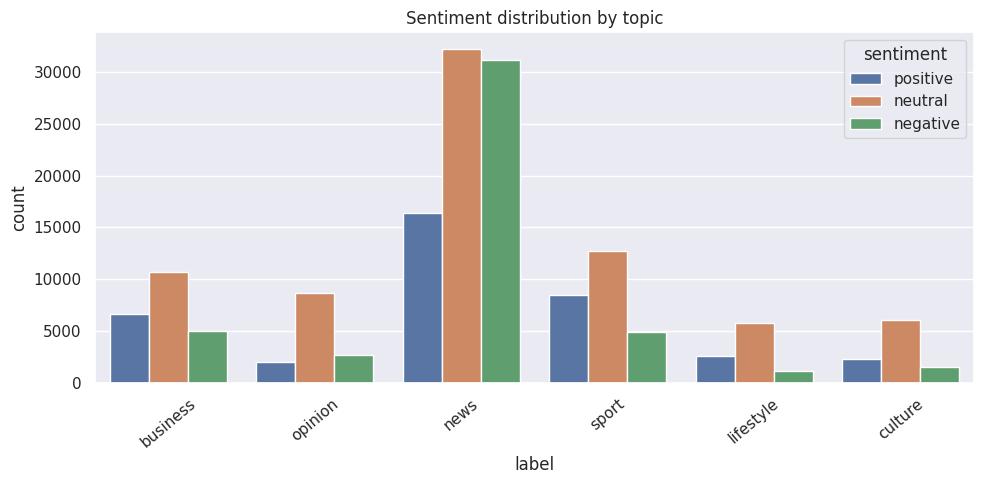

In [24]:
# Step 10: Plot sentiment by topic and overall

plt.figure(figsize=(10, 5))
sns.countplot(data=combined_df, x="label", hue="sentiment")
plt.title("Sentiment distribution by topic")
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()

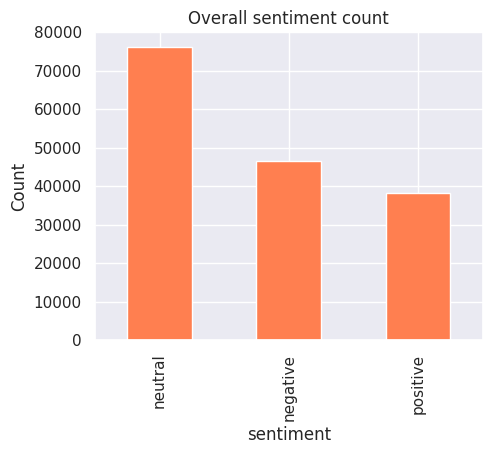

In [25]:
plt.figure(figsize=(5, 4))
combined_df["sentiment"].value_counts().plot(kind="bar", color="coral")
plt.title("Overall sentiment count")
plt.ylabel("Count")
plt.show()

In [26]:
# Step 11 (optional): Check common words in each topic

from collections import Counter

def top_words_for_label(df, label_name, top_n=10):
    subset = df.loc[df["label"] == label_name, "clean_text"].str.split()
    all_tokens = []
    for tokens in subset:
        all_tokens.extend(tokens)
    counter = Counter(all_tokens)
    return counter.most_common(top_n)

for lbl in sorted(combined_df["label"].unique()):
    print("\nTop words for label:", lbl)
    print(top_words_for_label(combined_df, lbl, top_n=10))


Top words for label: business
[('€m', 1210), ('irish', 1140), ('new', 964), ('us', 803), ('bank', 634), ('market', 544), ('dublin', 512), ('jobs', 500), ('ireland', 491), ('says', 455)]

Top words for label: culture
[('review', 587), ('irish', 346), ('new', 303), ('–', 262), ('music', 226), ('week', 185), ('life', 182), ('best', 180), ('reviews', 171), ('album', 158)]

Top words for label: lifestyle
[('new', 388), ('irish', 335), ('home', 291), ('€', 289), ('go', 225), ('€m', 199), ('dublin', 194), ('house', 178), ('–', 171), ('ireland', 165)]

Top words for label: news
[('says', 3011), ('man', 2974), ('new', 2269), ('us', 2161), ('irish', 1782), ('court', 1728), ('dublin', 1648), ('eu', 1262), ('may', 1228), ('two', 1170)]

Top words for label: opinion
[('diary', 655), ('irishmans', 574), ('irish', 518), ('ireland', 285), ('–', 274), ('times', 258), ('view', 242), ('new', 195), ('time', 193), ('us', 178)]

Top words for label: sport
[('ireland', 928), ('cup', 748), ('win', 633), ('ir